# Предсказание цен машин с Юлы




In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
import numpy as np # Библиотека работы с массивами
import matplotlib.pyplot as plt
import pandas as pd # Библиотека pandas
from sklearn.preprocessing import LabelEncoder, StandardScaler # Функции для нормализации данных
from sklearn import preprocessing


In [2]:
cars = pd.read_csv('cars_new.csv', sep=',')
cars[:5]

,mark,model,price,year,mileage,body,kpp,fuel,volume,power
0,kia,cerato,996000,2018,28000,седан,автомат,бензин,2.0,150.0
1,daewoo,nexia 1 поколение [2-й рестайлинг],140200,2012,60500,седан,механика,бензин,1.5,80.0
2,suzuki,jimny 3 поколение [рестайлинг],750000,2011,29000,внедорожник,автомат,бензин,1.3,85.0
3,bmw,x1 18 e84 [рестайлинг],970000,2014,49500,кроссовер,автомат,бензин,2.0,150.0
4,chevrolet,lacetti 1 поколение,205000,2007,151445,седан,механика,бензин,1.4,95.0


In [3]:
print(cars.values.shape)

(70119, 10)


In [4]:
# Создаём словарь поле - его индекс
def create_dict(s):
  ret = {}                          # Создаём пустой словарь
  for _id, name in enumerate(s):    # Проходим по всем парам - id и название
    ret.update({name: _id})         # Добавляем в словарь
  return ret

# Функция преобразования в one hot encoding
def to_ohe(value, d):
  arr = [0] * len(d)
  arr[d[value]] = 1
  return arr

In [5]:
# Создаём словари по всем текстовым колонкам
marks_dict = create_dict(set(cars['mark']))
models_dict = create_dict(set(cars['model']))
bodies_dict = create_dict(set(cars['body']))
kpps_dict = create_dict(set(cars['kpp']))
fuels_dict = create_dict(set(cars['fuel']))

# Запоминаем цены
prices = np.array(cars['price'], dtype=np.float)

# Запоминаем числовые параметры
# и нормируем
years = preprocessing.scale(cars['year'])
mileages = preprocessing.scale(cars['mileage'])
volumes = preprocessing.scale(cars['volume'])
powers = preprocessing.scale(cars['power'])

<ipython-input-5-006031011196>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prices = np.array(cars['price'], dtype=np.float)


In [6]:
print(fuels_dict)

{'бензин': 0, 'дизель': 1, 'гибрид': 2, 'электро': 3, 'газ': 4}


In [7]:
volumes.mean()

1.2879530757014324e-16

In [8]:
volumes.std()

1.0

In [9]:
print(powers)

[ 0.22905575 -0.95630346 -0.87163494 ...  0.22905575 -0.75309902
  2.34576862]


In [10]:
# Создаём пустую обучающую выборку
x = []
y = []

# Проходам по всем машинам
for _id, car in enumerate(np.array(cars)):
  # В y_train добавляем цену
  y.append(prices[_id])

  # В x_train объединяем все параметры
  # Категорийные параметры добавляем в виде ohe
  # Числовые параметры добавляем напрямую
  x_tr = to_ohe(car[0], marks_dict) + \
        to_ohe(car[1], models_dict) + \
        to_ohe(car[5], bodies_dict) + \
        to_ohe(car[6], kpps_dict) + \
        to_ohe(car[7], fuels_dict) + \
        [years[_id]] + \
        [mileages[_id]] + \
        [volumes[_id]] + \
        [powers[_id]]

  # Добавляем текущую строку в общий x_train
  x.append(x_tr)

# Превращаем лист в numpy.array
x = np.array(x, dtype=np.float)
y = np.array(y, dtype=np.float)

<ipython-input-10-b2ecf943cd42>:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(x, dtype=np.float)
<ipython-input-10-b2ecf943cd42>:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y, dtype=np.float)


In [11]:
# Выводим размеры выборок
print(x.shape)
print(y.shape)

(70119, 3208)
(70119,)


In [12]:
# Выводим один x_train
print(x[0,:20])
print(x[0,-20:])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          1.          0.          0.          0.
  0.          0.          0.          1.          0.          1.
  0.          0.          0.          0.          1.5200145  -1.40018212
  0.12288486  0.22905575]


In [13]:
# Выводим y_train
print(y[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]


In [14]:
y.shape

(70119,)

In [15]:
y.reshape(-1,1).shape

(70119, 1)

In [16]:
# Нормализуем y_train
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y.reshape(-1,1)).flatten()

# y_train.reshape(-1,1) добавляет одну размерность
# Это нужно потому, что y_scaler.fit_transform
# Требует двумерны вектор, массив примеров, которые надо нормализовать
# Он не умеет работать с одним примеров
# Поэтому мы делаем массив из одного примера
# На выходе он так же выдаёт массив примеров
# Но нам нужен только первый пример
# Поэтому мы делаем flatten() - уменьшение размерности

In [17]:
y.shape

(70119,)

In [18]:
# Выводим базовый и нормированный y_train
print(y[:10])
print(y_train_scaled[:10])

[ 996000.  140200.  750000.  970000.  205000.  985000.  589000.  500000.
 1320000.  270000.]
[ 0.75082432 -0.62135434  0.3563911   0.70913625 -0.51745486  0.73318706
  0.09824578 -0.04445567  1.27032173 -0.4132347 ]


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42, shuffle=True)

In [29]:
from tensorflow import keras
model_ula = Sequential()
model_ula.add(Dense(60, activation='relu', input_shape=(x_train.shape[1],)))
model_ula.add(Dropout(0.3))
model_ula.add(Dense(30, activation='relu'))
model_ula.add(Dropout(0.3))
model_ula.add(Dense(1, activation='linear'))
# training
model_ula.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.R2Score()])
history = model_ula.fit(x_train, y_train, validation_split=0.2, batch_size=70, epochs=100)


Epoch 1/100
561/561 [==============================] - 4s 6ms/step - loss: 653345423360.0000 - r2_score: -0.7392 - val_loss: 679267205120.0000 - val_r2_score: -0.6531
Epoch 2/100
561/561 [==============================] - 3s 5ms/step - loss: 625538957312.0000 - r2_score: -0.6651 - val_loss: 626583666688.0000 - val_r2_score: -0.5249
Epoch 3/100
561/561 [==============================] - 2s 4ms/step - loss: 545718599680.0000 - r2_score: -0.4527 - val_loss: 522946510848.0000 - val_r2_score: -0.2727
Epoch 4/100
561/561 [==============================] - 2s 4ms/step - loss: 432100605952.0000 - r2_score: -0.1502 - val_loss: 403818676224.0000 - val_r2_score: 0.0172
Epoch 5/100
561/561 [==============================] - 2s 4ms/step - loss: 324999774208.0000 - r2_score: 0.1349 - val_loss: 311695114240.0000 - val_r2_score: 0.2414
Epoch 6/100
561/561 [==============================] - 4s 6ms/step - loss: 258959917056.0000 - r2_score: 0.3107 - val_loss: 259077210112.0000 - val_r2_score: 0.3695
Epo

In [30]:
y_pred = model_ula.predict(x_test)

658/658 [==============================] - 3s 4ms/step


In [34]:
history.history['r2_score']

[-0.7391530275344849,
 -0.6651339530944824,
 -0.4526560306549072,
 -0.1502162218093872,
 0.13487863540649414,
 0.31067025661468506,
 0.408348023891449,
 0.4478238821029663,
 0.48104989528656006,
 0.5036903619766235,
 0.5227642059326172,
 0.5340608358383179,
 0.543245792388916,
 0.5637110471725464,
 0.5626002550125122,
 0.5751224160194397,
 0.5710893869400024,
 0.5912693738937378,
 0.5985039472579956,
 0.59898841381073,
 0.5994068384170532,
 0.6002690196037292,
 0.6116350889205933,
 0.6134254932403564,
 0.6288625597953796,
 0.6232446432113647,
 0.6300882697105408,
 0.6325081586837769,
 0.6416610479354858,
 0.6418666839599609,
 0.6473779678344727,
 0.648495078086853,
 0.6499044895172119,
 0.6624093651771545,
 0.6695519685745239,
 0.6634944081306458,
 0.6724697947502136,
 0.6761224269866943,
 0.6797453761100769,
 0.6864478588104248,
 0.6836085319519043,
 0.6967527866363525,
 0.6912962794303894,
 0.6953997611999512,
 0.696679949760437,
 0.7041571140289307,
 0.7046034336090088,
 0.706331491

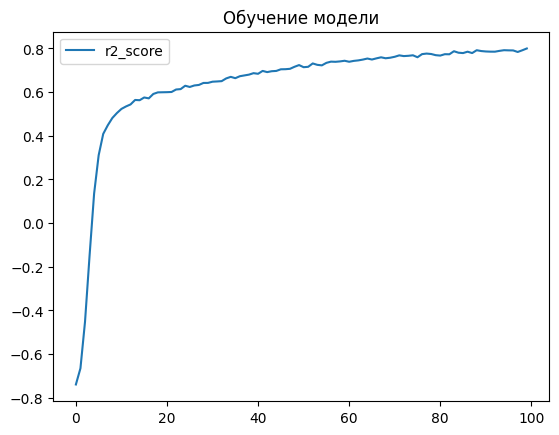

In [35]:
plt.plot(history.history['r2_score'], label='val_r2_score')
plt.title('Обучение модели')
plt.legend(['r2_score'])
plt.show()

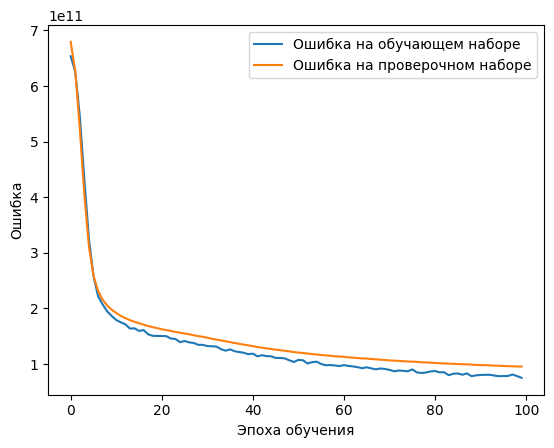

In [36]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()